## Step 1: Load your data, including testing/training split from Project 1.

In [2]:
# Initial code copied from Project 1
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("oasis_longitudinal.csv")

# First, drop NaN value rows on the non-split data to keep it balanced for the split
# Drop rows with null/missing values in SES and MMSE columns (identified by using data.info())
data = data.dropna(axis=0)

# Define the predictor and the feature set
X = data.drop('Group', axis=1)
y = data['Group']

# Finally, divide into training and test sets, add random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


## Step 2: (If not already done in Project 1) Prepare your data

In [3]:
# Code copied from Project 1

# Get rid of unecessary features: handedness (since all are right handed), MR delay time, Subject ID, MRI ID, Visit number
X_train = X_train.drop(['Hand', 'MR Delay', 'Subject ID', 'MRI ID', 'Visit'], axis=1)
X_test = X_test.drop(['Hand', 'MR Delay', 'Subject ID', 'MRI ID', 'Visit'], axis=1)

# Convert "M/F" categorical attribute to int. F is class '0' and M is class '1'.
X_train['M/F'].replace(['M', 'F'], [0, 1], inplace=True)
X_test['M/F'].replace(['M', 'F'], [0, 1], inplace=True)

# Since we are interested in predicting dementia based on biological attributes, not conversion to it, 
# transform "Converted" predictor category to "Demented."
y_train = y_train.str.replace('Converted', 'Demented')
y_test = y_test.str.replace('Converted', 'Demented')

# Encode the categorical predictor "Demented" to class '0' vs "Nondemented" to class '1'.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Feature scaling. Decided to use StandardScaler instead of MinMaxScaler so that 
# the mean was 0 and standard deviation constant i.e. create Gaussian data.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)



## Step 3: Examine your target attribute.

Nondemented    0.536723
Demented       0.463277
Name: Group, dtype: float64


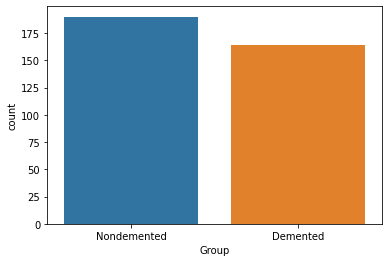

In [4]:
import seaborn as sns
%matplotlib inline

# Transform "Converted" to "Demented" for the pre-split data
y = y.str.replace('Converted', 'Demented')

# Plot the categorical target variable from the pre-split data
sns.countplot(x=y)

# Show frequencies. Each outcome is approximately equally represented.
print(y.value_counts(normalize=True))

## Step 4: Select two of the following supervised learning algorithms

In [5]:
# First algorithm: Logistic regression
from sklearn.linear_model import LogisticRegression

# Instantiate and fit the LogisticRegression model. When running the Logistic Regression algorithm, I got a 
# convergence error/warning (for lbfgs solver), though it still ran. Default iterations were 100, so I increased to 1000 and
# that resolved the issue, but notably, only after scaling the data. Apparently higher iterations or failing to converge
# reduces the confidence in the prediction and scoring.
logreg = LogisticRegression(max_iter=1000)

# Second algorithm: Decision tree
from sklearn.tree import DecisionTreeClassifier

#Instantiate and fit the Decision Tree Classifier. Set random_state to 2 for reproducibility.
dectree = DecisionTreeClassifier(random_state=2)


## Step 5: For each of your selected models

In [7]:
# Import tools for cross validation and scoring
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# FIRST, FOR LOGISTIC REGRESSION. Run with the default parameters using cross-validation.
print("Logistic regression scoring metrics using default parameters:")
print("\n\tCross validation scores: {}\n".format(cross_val_score(logreg, X_train, y_train, cv=5)))

# Fit model to scaled training data and predict against the test data.
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

# Calculate precision, recall, F1. Use classification_report to show a table of the metrics.
print(classification_report(y_test, y_pred))

# CANNOT calculate r2, RMSE, and MAE for logistic regression, but can accuracy scores. Note how scaling vastly improved scores.
print("\tAccuracy score on un-scaled training data: {}".format(logreg.score(X_train, y_train)))
print("\tAccuracy score on un-scaled test data: {}".format(logreg.score(X_test, y_test)))
print("\tAccuracy score on SCALED training data: {}".format(logreg.score(X_train_scaled, y_train)))
print("\tAccuracy score on SCALED test data: {}".format(logreg.score(X_test_scaled, y_test)))

# Grid search using the inverse regularization strength C (default = 1).
param_grid = {'C': [0.001, 0.01, 1, 10, 100]}
logregGS = GridSearchCV(logreg, param_grid=param_grid)
logregGS.fit(X_train_scaled, y_train)
print('\n\tBest C from GridSearch: {}'.format(logregGS.best_params_))
print('\tBest score from GridSearch: {}'.format(logregGS.best_score_))

# Note: did not re-run model after Grid Search because best parameter was C = 1, which is the default C for
# sklearn's Logistic Regression.


# SECOND, FOR DECISION TREE CLASSIFIER. Perform cross-validation with default parameters. Use unscaled training data.
print("\n\n\nDecision tree scoring metrics using default parameters:")
print("\n\tCross validation scores: {}\n".format(cross_val_score(dectree, X_train, y_train, cv=5)))

# Fit dectree to training data and predict against the test data.
dectree.fit(X_train, y_train)
y_pred = dectree.predict(X_test)

# Calculate precision, recall, F1. Use classification_report to show a table of the metrics.
print(classification_report(y_test, y_pred))

# Accuracy scoring.
print("\tAccuracy score on training data: {}".format(dectree.score(X_train, y_train)))
print("\tAccuracy score on test data: {}".format(dectree.score(X_test, y_test)))

# Grid search using DecisionTree parameters of 'criterion,' 'max_depth', and 'max_features'
param_grid = {'criterion': ['entropy', 'gini'], 'max_depth': list(range(1, 9)), 'max_features': list(range(1, 10))}
dectreeGS = GridSearchCV(dectree, param_grid=param_grid)
dectreeGS.fit(X_train, y_train)
print('\n\tBest parameters from GridSearch: {}'.format(dectreeGS.best_params_))
print('\tBest score from GridSearch: {}'.format(dectreeGS.best_score_))

# Re-run the model with the best parameters
dectree_best = DecisionTreeClassifier(criterion = 'entropy', max_depth=5, max_features=8, random_state=2)

dectree_best.fit(X_train, y_train)
y_pred = dectree_best.predict(X_test)

# New classification report
print('\n\nRe-run the model with the best parameters from Grid Search\n')
print(classification_report(y_test, y_pred))

# New accuracy scoring.
print("\tAccuracy score on training data: {}".format(dectree_best.score(X_train, y_train)))
print("\tAccuracy score on test data: {}".format(dectree_best.score(X_test, y_test)))

Logistic regression scoring metrics using default parameters:

	Cross validation scores: [0.9122807  0.94736842 0.92982456 0.96428571 0.89285714]

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        33
           1       0.93      1.00      0.96        38

    accuracy                           0.96        71
   macro avg       0.96      0.95      0.96        71
weighted avg       0.96      0.96      0.96        71

	Accuracy score on un-scaled training data: 0.5371024734982333
	Accuracy score on un-scaled test data: 0.5352112676056338
	Accuracy score on SCALED training data: 0.9399293286219081
	Accuracy score on SCALED test data: 0.9577464788732394

	Best C from GridSearch: {'C': 1}
	Best score from GridSearch: 0.9398496240601505



Decision tree scoring metrics using default parameters:

	Cross validation scores: [0.89473684 0.89473684 0.92982456 0.89285714 0.83928571]

              precision    recall  f1-score   support

      